<a href="https://colab.research.google.com/github/wdrdg/wdrdg/blob/master/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load the data

In [ ]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8001054465787341777]

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]
# Rescale the images from [0,255] to the [0.0,1.0] range.
# x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

# Change the 4D array to 2D then 3D




flatten the point in the row order--feature is the point on the row

In [ ]:
def change_dim(x_data):
  result=[]
  
  for image in x_data:
    image_ary = image.flatten()
    image_ary = image_ary.astype(np.float32)
    result.append(image_ary)
  
  result=np.asarray(result)

  return result

#Data process


In [ ]:
x_train = change_dim(x_train)
x_train/=255

x_train, x_vali, y_train, y_vali = train_test_split(x_train,y_train, test_size=0.2)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_vali = x_vali.reshape(x_vali.shape[0], x_vali.shape[1], 1)

x_test = change_dim(x_test)
x_test = x_test/255
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

import copy
x_unnormalized_train = copy.deepcopy(x_train)
x_unnormalized_test = copy.deepcopy(x_test)

y_train_oh and y_test_oh are the final label dataset we will use in the train and test

In [ ]:
y_train_oh = np.zeros((y_train.size, 10))
for i, row in enumerate(y_train_oh):
    row[y_train[i]] = 1
y_train_oh = y_train_oh.reshape(y_train_oh.shape[0], y_train_oh.shape[1], 1)  

y_vali_oh = np.zeros((y_vali.size, 10))
for i, row in enumerate(y_vali_oh):
    row[y_vali[i]] = 1
y_vali_oh = y_vali_oh.reshape(y_vali_oh.shape[0], y_vali_oh.shape[1], 1)  

y_test_oh = np.zeros((y_test.size, 10))
for i, row in enumerate(y_test_oh):
    row[y_test[i]] = 1
y_test_oh = y_test_oh.reshape(y_test_oh.shape[0], y_test_oh.shape[1], 1)  

In [ ]:
#print(y_train_oh[0,:,:].shape)

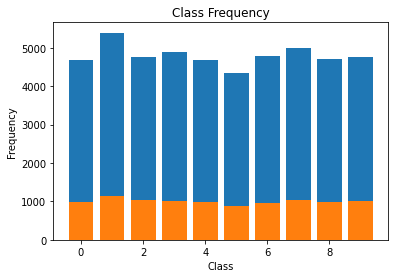

In [ ]:
#Class distribution visualization
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(y_test, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

# Multilayer Perceptron

In [ ]:
sigmoid = lambda z: 1./ (1 + np.exp(-z))
sigmoid_prime = lambda z: sigmoid(z) * (1 - sigmoid(z))
ReLU = lambda z: np.maximum(z, 0)
def ReLU_prime(z):
     z[z<=0] = 0
     z[z>0] = 1
     return z
tanh = lambda z: (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
tanh_prime = lambda z: 1-tanh(z)**2
softmax = lambda z: np.exp(z) / np.sum(np.exp(z), axis=0)
# softmax derivative todo
# regularization todo

class MLP(object):
    
    def __init__(self, sizes, activation_func, activation_func_prime, lam, beta1):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.weights = [np.random.randn(n,m)*np.sqrt(2/(m+n)) for m,n in zip(sizes[:-1], sizes[1:])]   
        # random initialize with some trick
        self.biases = [np.random.randn(n,1) for n in sizes[1:]]
        self.activation_func = activation_func
        self.activation_func_prime = activation_func_prime
        self.lam = lam # lam is lambda, the amount of l2
        self.beta1 = beta1 

    def feed_forward(self, x):'
        value = x
        for i in range(len(self.weights)-1):
            value = self.activation_func(np.dot(self.weights[i], value) + self.biases[i])
        y = softmax(np.dot(self.weights[-1], value) + self.biases[-1])
        return y

    def backprop(self, x, y, lam):
        delta_nabla_b = [np.zeros(b.shape) for b in self.biases]
        delta_nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        activations = [x]
        zs = []
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            z = np.dot(w, activations[-1]) + b
            zs.append(z)
            activation = self.activation_func(z)
            activations.append(activation)
        
        z = np.dot(self.weights[-1], activations[-1]) + self.biases[-1] 
        zs.append(z)
        activation = softmax(z)
        activations.append(activation)
        delta = activations[-1] - y
        delta_nabla_b[-1] = delta
        delta_nabla_w[-1] = np.dot(delta, activations[-2].T) + lam*self.weights[-1] 
        for l in range(2, self.num_layers):
            delta = np.dot(self.weights[-l+1].transpose(), delta) * self.activation_func_prime(zs[-l])
            delta_nabla_b[-l] = delta
            delta_nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) + lam*self.weights[-l]
        return delta_nabla_b, delta_nabla_w


    def update_mini_batch(self, mini_batch_image, mini_batch_label, eta, mini_batch_size, beta1):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        last_w = [np.zeros(w.shape) for w in self.weights]
        for x,y in zip(mini_batch_image, mini_batch_label):
            delta_nabla_b, delta_nabla_w = self.backprop(x, y, self.lam)
            delta_nabla_w = [beta1*lw + (1-beta1)*dnw for lw, dnw in zip(last_w, delta_nabla_w)]# momentum
            last_w = [dnb for dnb in delta_nabla_w]

            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/mini_batch_size)*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/mini_batch_size)*nb for b, nb in zip(self.biases, nabla_b)]

    def fit(self, train_image, train_label, epochs, mini_batch_size, eta):
        for j in range(epochs):
            mini_batches_image = [train_image[k:k+mini_batch_size] for k in range(0, len(train_image), mini_batch_size)]
            mini_batches_label = [train_label[k:k+mini_batch_size] for k in range(0, len(train_label), mini_batch_size)]
            for mini_batch_image, mini_batch_label in zip(mini_batches_image, mini_batches_label):
                self.update_mini_batch(mini_batch_image, mini_batch_label, eta, mini_batch_size, beta1=self.beta1)   

    def fit_and_evaluate(self, train_image, train_label, epochs, mini_batch_size,eta,test_x,test_y):
        accuracies = []
        for j in range(epochs):
            mini_batches_image = [train_image[k:k+mini_batch_size] for k in range(0, len(train_image), mini_batch_size)]
            mini_batches_label = [train_label[k:k+mini_batch_size] for k in range(0, len(train_label), mini_batch_size)]
            for mini_batch_image, mini_batch_label in zip(mini_batches_image, mini_batches_label):
                self.update_mini_batch(mini_batch_image, mini_batch_label, eta, mini_batch_size, beta1=self.beta1) 
            accuracies.append( self.evaluate_acc(self.predict(test_x),test_y) )  
        return accuracies

    def predict(self, images):
        result = []
        accuracy = []
        for img in images:
              predict_label = self.feed_forward(img)
              result.append(predict_label)
              #result.append(np.argmax(predict_label))
              #accuracy.append(self.evaluate_acc())
        return result

    def evaluate_acc(self, predicted_ys, true_ys): 
        result = 0
        for predicted_y, true_y in zip(predicted_ys, true_ys):
            if np.argmax(predicted_y) == np.argmax(true_y):
                result += 1
        return result/len(true_ys)
        #return np.sum(y_predict == y_test) / len(y_test) #！！！！！！！！！！！！！

# testing

# Hyperparam tuning for 0 hidden layer with ReLU activation

In [ ]:
#no hidden layer
identity_activation = lambda z: z
# bestAcc = float("-inf")
best_LR = 0
accs = []
learning_rate = [0.01,0.05,0.1]
for eta in learning_rate:
  MLP1 = MLP([784,10], identity_activation,identity_activation, 0 ,beta1=0.95)
  acc=MLP1.fit_and_evaluate(x_train, y_train_oh,epochs=20, mini_batch_size=128, eta=eta ,test_x=x_vali,test_y=y_vali_oh)
  accs.append(acc[-1])
  print(accs)
  # if(acc[-1] > bestAcc) :
  #   bestAcc = acc[-1]
  #   best_LR = learning_rate

bestAcc = np.max(accs)
best_LR = learning_rate[np.argmax(accs)]
print("The best validation accuracy is {0} for no hidden layer with ReLU activation, produced learning_rate={1}".format(bestAcc,best_LR))  


[0.89425]
[0.89425, 0.9143333333333333]
[0.89425, 0.9143333333333333, 0.9171666666666667]
The best validation accuracy is 0.9171666666666667 for no hidden layer with ReLU activation, produced learning_rate=0.1


# Hyperparam tuning for 1 hidden layer with ReLU activation

In [ ]:
#one hidden layer
# TODO using validation set for tuning
identity_activation = lambda z: z
bestAcc = float("-inf")
best_LR = 0
accs = []
learning_rate = [0.005, 0.01, 0.02]
for eta in learning_rate:
  MLP1 = MLP([784,128,10], ReLU,ReLU_prime,0 ,beta1=0.95)
  acc=MLP1.fit_and_evaluate(x_train, y_train_oh,epochs=20, mini_batch_size=128,eta=eta,test_x=x_vali,test_y=y_vali_oh)
  accs.append(acc[-1])
  print(accs)
  # if(acc[-1] > bestAcc) :
  #   bestAcc = acc[-1]
  #   best_LR = learning_rate

bestAcc = np.max(accs)
best_LR = learning_rate[np.argmax(accs)]
print("The best validation accuracy is {0} for one-hidden layer with ReLU activation, produced learning_rate={1}".format(bestAcc,best_LR))  


[0.905]
[0.905, 0.9188333333333333]
[0.905, 0.9188333333333333, 0.9359166666666666]
The best validation accuracy is 0.9359166666666666 for one-hidden layer with ReLU activation, produced learning_rate=0.02


# Hyperparam tuning for 2 hidden layer with ReLU activation (only learning rate for 3.1)

In [ ]:
#two hidden layer
# TODO using validation set for tuning
identity_activation = lambda z: z
bestAcc = float("-inf")
best_LR = 0
accs = []
learning_rate = [0.001, 0.005, 0.01]
for eta in learning_rate:
  MLP1 = MLP([784,128,128,10], ReLU,ReLU_prime,0 ,beta1=0.95)
  acc=MLP1.fit_and_evaluate(x_train, y_train_oh,epochs=20, mini_batch_size=128,eta=eta,test_x=x_vali,test_y=y_vali_oh)
  accs.append(acc[-1])
  print(accs)
  # if(acc[-1] > bestAcc) :
  #   bestAcc = acc[-1]
  #   best_LR = learning_rate

bestAcc = np.max(accs)
best_LR = learning_rate[np.argmax(accs)]
print("The best validation accuracy is {0} for two-hidden layer with ReLU activation, produced learning_rate={1}".format(bestAcc,best_LR)) 

[0.8696666666666667]
[0.8696666666666667, 0.9165]
[0.8696666666666667, 0.9165, 0.931]
The best validation accuracy is 0.931 for one-hidden layer with ReLU activation, produced learning_rate=0.01


# 3.1 Comparison across 3 different MLP models

In [ ]:
identity_activation = lambda z: z
#MLP with with no hidden layer
MLP1 = MLP([784,10], identity_activation, identity_activation, lam=0,beta1=0.95)
acc1=MLP1.fit_and_evaluate(x_train, y_train_oh, epochs=50, mini_batch_size=128,eta=0.1,test_x=x_test,test_y=y_test_oh)
#MLP with with one hidden layer of 128 units and using ReLU activation 
MLP2 = MLP([784,128,10], ReLU, ReLU_prime, lam=0, beta1=0.95)
acc2=MLP2.fit_and_evaluate(x_train, y_train_oh,epochs=50, mini_batch_size=128,eta=0.02,test_x=x_test,test_y=y_test_oh)
#MLP with with 2 hidden layers of 128 units and using ReLU activation
MLP3 = MLP([784,128,128,10], ReLU, ReLU_prime, lam=0, beta1=0.95)
acc3=MLP3.fit_and_evaluate(x_train, y_train_oh,epochs=50, mini_batch_size=128,eta=0.01,test_x=x_test,test_y=y_test_oh)

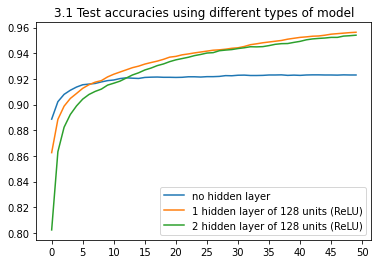

In [ ]:
#The performances of the three models compared
plt.xticks(range(0,60,5))
plt.title("3.1 Test accuracies using different types of model")
plt.plot(acc1, '-', label="no hidden layer")
plt.plot(acc2,'-', label="1 hidden layer of 128 units (ReLU)")
plt.plot(acc3, '-', label="2 hidden layer of 128 units (ReLU)")
plt.legend()
plt.show()

# 3.2 examining the performance of the 2-hidden-layer MLP when given different activation functions

In [ ]:
#ReLU activation
MLP1 = MLP([784,128,128,10], ReLU,ReLU_prime, lam=0,beta1=0.95)
acc1=MLP1.fit_and_evaluate(x_train, y_train_oh, epochs=20, mini_batch_size=128,eta=0.01,test_x=x_test,test_y=y_test_oh)
#sigmoid activation
MLP2 = MLP([784,128,128,10], sigmoid, sigmoid_prime, lam=0,beta1=0.95)
acc2=MLP2.fit_and_evaluate(x_train, y_train_oh,epochs=20, mini_batch_size=128,eta=0.01,test_x=x_test,test_y=y_test_oh)
#tanh activation
MLP3 = MLP([784,128,128,10],tanh,tanh_prime, lam=0,beta1=0.95)
acc3=MLP3.fit_and_evaluate(x_train, y_train_oh, epochs=20,mini_batch_size=128,eta=0.01,test_x=x_test,test_y=y_test_oh)

acc4=MLP2.fit_and_evaluate(x_train, y_train_oh,epochs=20, mini_batch_size=128,eta=0.05,test_x=x_test,test_y=y_test_oh)

acc5=MLP2.fit_and_evaluate(x_train, y_train_oh,epochs=20, mini_batch_size=128,eta=0.1,test_x=x_test,test_y=y_test_oh)
#performances compared
plt.xticks(range(0,30,5))
plt.title("3.2 Test accuracies using different types of model")
plt.plot(acc1, '-', label="ReLU activation(eta=0.01)")
plt.plot(acc2,'-', label="sigmoid activation(eta=0.01)")
plt.plot(acc3, '-', label="tanh activation(eta=0.01)")
plt.plot(acc4, '-', label="sigmoid activation(eta=0.05)")
plt.plot(acc5, '-', label="sigmoid activation(eta=0.1)")
plt.legend()
plt.show()

# 3.3 2-hidden-layer MLP (with ReLU activation) performance when having or not having L2 regularization

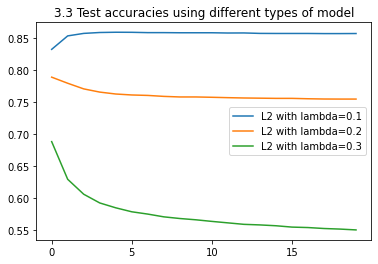

In [ ]:
#no L2 regularization
MLP1 = MLP([784,128,10], ReLU,ReLU_prime, lam=0.1,beta1=0.95)
acc1=MLP1.fit_and_evaluate(x_train, y_train_oh, epochs=20, mini_batch_size=128,eta=0.02,test_x=x_test,test_y=y_test_oh)
#L2 with lambda=0.1
MLP2 = MLP([784,128,10], ReLU,ReLU_prime, lam=0.2,beta1=0.95)
acc2=MLP2.fit_and_evaluate(x_train, y_train_oh,epochs=20, mini_batch_size=128,eta=0.02,test_x=x_test,test_y=y_test_oh)
#L2 with lambda=0.2
MLP3 = MLP([784,128,10],ReLU,ReLU_prime, lam=0.3,beta1=0.95)
acc3=MLP3.fit_and_evaluate(x_train, y_train_oh, epochs=20,mini_batch_size=128,eta=0.02,test_x=x_test,test_y=y_test_oh)
#performances compared
plt.xticks(range(0,30,5))
plt.title("3.3 Test accuracies using different types of model")
plt.plot(acc1, '-', label="L2 with lambda=0.1")
plt.plot(acc2,'-', label="L2 with lambda=0.2")
plt.plot(acc3, '-', label="L2 with lambda=0.3")
plt.legend()
plt.show()

# 3.4 2-hidden-layer MLPs' performance when having/not having normalized input

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


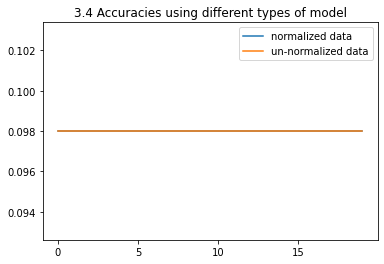

In [ ]:
#with normalized input
#大概会去用加了lambda的模型去跑？
MLP1 = MLP([784,128,128,10], ReLU,ReLU_prime, lam=0,beta1=0.95)
acc1=MLP1.fit_and_evaluate(x_train, y_train_oh, epochs=25, mini_batch_size=128,eta=0.01,test_x=x_test,test_y=y_test_oh)
#with un-normalized input
MLP2 = MLP([784,128,128,10], ReLU,ReLU_prime, lam=0,beta1=0.95)
acc2=MLP2.fit_and_evaluate(x_unnormalized_train, y_train_oh,epochs=25, mini_batch_size=128,eta=0.01,test_x=x_unnormalized_test,test_y=y_test_oh)
#performances compared
plt.xticks(range(0,30,5))
plt.title("3.4 Test accuracies using different types of model")
plt.plot(acc1, '-', label="normalized data")
plt.plot(acc2,'-', label="un-normalized data")
plt.legend()
plt.show()

# Creativity 1: MLP performance vs number of units in hidden layers

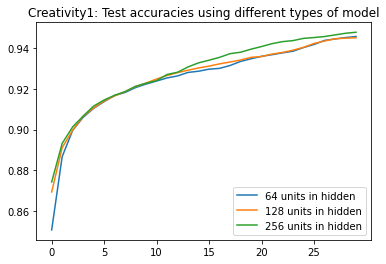

In [ ]:
#MLP with with one hidden layer of 128 units and using ReLU activation 
MLP1 = MLP([784,64,10], ReLU, ReLU_prime, lam=0, beta1=0.95)
acc1=MLP1.fit_and_evaluate(x_train, y_train_oh,epochs=30, mini_batch_size=128,eta=0.02,test_x=x_test,test_y=y_test_oh)
#MLP with with one hidden layer of 128 units and using ReLU activation 
MLP1 = MLP([784,128,10], ReLU, ReLU_prime, lam=0, beta1=0.95)
acc2=MLP1.fit_and_evaluate(x_train, y_train_oh,epochs=30, mini_batch_size=128,eta=0.02,test_x=x_test,test_y=y_test_oh)
#MLP with with one hidden layer of 128 units and using ReLU activation 
MLP1 = MLP([784,256,10], ReLU, ReLU_prime, lam=0, beta1=0.95)
acc3=MLP1.fit_and_evaluate(x_train, y_train_oh,epochs=30, mini_batch_size=128,eta=0.02,test_x=x_test,test_y=y_test_oh)
#performances compared
plt.xticks(range(0,30,5))
plt.title("Creativity1: Test accuracies using different types of model")
plt.plot(acc1, '-', label="64 units in hidden")
plt.plot(acc2,'-', label="128 units in hidden")
plt.plot(acc3, '-', label="256 units in hidden")
plt.legend()
plt.show()

# Creativity 2: MLP performance vs training dataset size

In [ ]:
#splitting the data
train_x_2 = x_train[:10**2]
train_y_2 = y_train_oh[:10**2]
train_x_3 = x_train[:10**3]
train_y_3 = y_train_oh[:10**3]
train_x_4 = x_train[:10**4]
train_y_4 = y_train_oh[:10**4]
#MLP with with one hidden layer of 128 units and using ReLU activation, trained on 10^2 images
MLP = MLP([784,256,10], ReLU, ReLU_prime, lam=0, beta1=0.95)
acc1=MLP.fit_and_evaluate(train_x_2, train_y_2,epochs=30, mini_batch_size=128,eta=0.02,test_x=x_test,test_y=y_test_oh)
#MLP with with one hidden layer of 128 units and using ReLU activation, trained on 10^3 images
MLP = MLP([784,256,10], ReLU, ReLU_prime, lam=0, beta1=0.95)
acc2=MLP.fit_and_evaluate(train_x_3, train_y_3,epochs=30, mini_batch_size=128,eta=0.02,test_x=x_test,test_y=y_test_oh)
#MLP with with one hidden layer of 128 units and using ReLU activation, trained on 10^4 images
MLP = MLP([784,256,10], ReLU, ReLU_prime, lam=0, beta1=0.95)
acc3=MLP.fit_and_evaluate(train_x_4, train_y_4,epochs=30, mini_batch_size=128,eta=0.02,test_x=x_test,test_y=y_test_oh)
#MLP with with one hidden layer of 128 units and using ReLU activation, trained on 60000 (full set) images
MLP = MLP([784,256,10], ReLU, ReLU_prime, lam=0, beta1=0.95)
acc4=MLP.fit_and_evaluate(x_train, y_train_oh,epochs=30, mini_batch_size=128,eta=0.02,test_x=x_test,test_y=y_test_oh)
#performances compared
plt.xticks(range(0,30,5))
plt.title("Creativity 2: Test accuracies using different types of model")
plt.plot(acc1, '-', label="10^2 images")
plt.plot(acc2,'-', label="10^3 images")
plt.plot(acc3, '-', label="10^4 images")
plt.plot(acc4, '-', label="60000 images")
plt.legend()
plt.show()